Reference : https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial by Fabien Daniel(September 2017)

# Predicting flight delays [Tutorial]

In this notebook, I develop a model aimed at predicting flight delays at take-off, The purpose is not to obtain the best possible prediction but rather to emphasize on the various steps needed to build such a model. Along this path, I then put in evidence some <b>basic but important</b> concepts. Among then, I comment on the importance of the separation of the dataset during the training stage and how <b>cross-validation</b> helps in determining accurate model parameters. I show how to build <b>linear</b> and <b>polynomial</b> models for <b>univariate</b> or <b>multivariate regressions</b> and also, I give some insight on the reason why <b>regularisation</b> helps us in developing models that generalize well.

From a _<b>technical point of view</b>_. the main aspects of python covered throughout the notebook are:

1. <b>visualization</b> : matplotlib, seaborn, basemap
2. <b>data manipulation</b> : pandas, numpy
3. <b>modeling</b> : sklearn, scipy
4. <b>class definition</b> : regression, figures

During the EDA, I intended to create good quality figures from which the information would be easily accessible at a first glance. An important aspect of the data scientist job consists in divulgating its findings to people who do not necessarily have knowledge in the technical aspects data scientists master. Graphics are surely the most powerful tool to achieve that goal, and mastering visualization techniques thus seems important.

Also, as soon as an action is repeated (mostly at identical) a few times, I tend to write classes or functions and eventually embed them in loops. Doing so is sometimes longer than a simple _copy-paste-edit_ process but, on the one hand, this improves the readibility of the code and most importantly, this reduces the number of lines of code (and so, the number of opportunities to introduce mistakes !!). In the current notebook, I defined classes in the modeling part in order to perform regressions. I also defined a class to wrap the making of figures. This allows to create stylish figures, by tuning the matplotlib parameters, that can be subsequently re-used thanks to that template. I feel that this could be useful to create nice looking graphics and then use them extensively once you are satisfied with the tuning. Moreover, this helps to keep some homogeneity in your plots.

This notebook is composed of three parts : cleaning (section 1), exploration (section 2-5) and modeling (section 6).

_<b>Preamble</b> : overvie of the datatset_

<b>1. Cleaning</b>

        1.1 Dates and times
        1.2 Filling factor
   
<b>2. Comparing airlines</b>

        2.1 Basic statistical description of airlines
        2.2 Delays distribution : establishing the ranking of airlines
        
<b>3. Delays take-off or landing?</b>


<b>4. Relation between the origin airport and delays</b>

        4.1 Geographical area covered by airlines
        4.2 How the origin airport impact delays
        4.3 Flights with usual delays?
    
<b>5. Temporal variability of delays</b>


<b>6. Predicting flight delays </b>

        6.1 Model no1 : one airline, one airport
            6.1.1 Pitfalls
            6.1.2 Polynomial degree : splitting the dataset
            6.1.3 Model test : prediction of end-January delays
        
        6.2 Model no2 : one airline, all airports
            6.2.1 Linear regression
            6.2.2 Polynomial regression
            6.2.3 Setting the free parameters
            6.2.4 Model test : prediction of end-January delays
        
        6.3 Model no3 : Accounting for destinations
            6.3.1 Choice of the free parameters
            6.3.2 Model test : prediction of end-January delays
    
<b>Conclusion</b>

## Preamble : Overview of the dataset
First, I load all the packages that will be needed during this project : 

In [28]:
# Basemap Import - PROJ_LIB 에러 해결
import os
os.environ['PROJ_LIB'] = r'c:\Users\HJ\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [29]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

and then, I read the file that contains the details of all the flights that occured in 2015. I output some informations concerning the types of the variables in the dataframe and the quantity of null values for each variable:

In [30]:
df = pd.read_csv('../kaggle/data/Predicting flight delays/flights.csv', low_memory = False)
print('Dataframe dimensions:', df.shape)
#______________________________________________________________________________
# gives some infos on columns types and number of null values
tab_info = pd.DataFrame(df.dtypes).T.rename(index = {0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index = {0: 'null values(nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum() / df.shape[0] * 100)
                           .T.rename(index = {0: 'null values (%)'}))
tab_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values(nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


Each entry of the flight.csv file corresponds to a flight and we see that more than 5,800,000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

   -<b>YEAR, MONTH, DAY, DAY_OF_WEEK</b> : dates of the flights
   
   -<b>AIRLINE</b> : An identification number assigned by US DOT to identify a unique airline

-<b>ORIGIN_AIRPORT</b> and <b> DESTINATION_AIRPORT</b> : code attributed by IATA to identify the airports

-<b>SCHEDULED_DEPARTURE</b> and <b>SCHEDULED_ARRIVAL</b> : scheduled times of take-off and landing

-<b>DEPARTURE_TIME</b> and <b>ARRIVAL_TIME</b> : real times at which take-off and landing took place

-<b>DEPARTURE_DELAY</b> and <b>ARRIVAL_DELAY</b> : difference (in minutes) between planned and real times

-<b>DISTANCE</b> : distance (in miles)
    
An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [31]:
airports = pd.read_csv("../kaggle/data/Predicting flight delays/airports.csv")

To have a global overview of the geographial area covered in this dataset, we can plot the airports location and indicate the number of flights recorded during year 2015 in each of them:

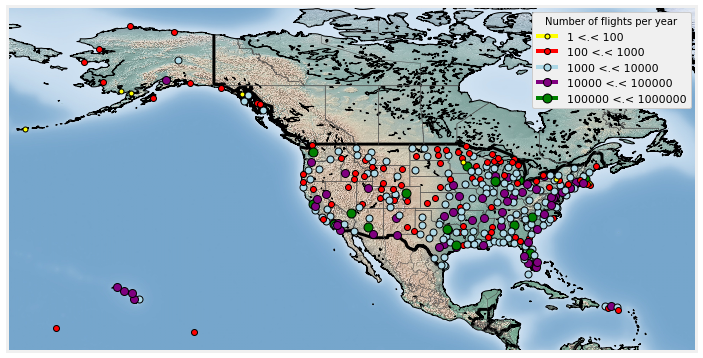

In [33]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()
#_____________________________
plt.figure(figsize = (11, 11))
#______________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []

for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i + 1]))
#_____________________________________________________
map = Basemap(resolution = 'i', llcrnrlon = -180, urcrnrlon = -50,
             llcrnrlat = 10, urcrnrlat = 75, lat_0 = 0, lon_0 = 0)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color = '0.3')
#_______________________________________
# put airports on map
for index, (code, y, x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x,y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker = 'o', markersize = ind + 5, markeredgewidth = 1, color = colors[ind],
            markeredgecolor = 'k', label = labels[ind])
#____________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000', '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop = {'size' : 11},
             title = 'Number of flights per year', frameon = True, framealpha = 1)
plt.show()    

In [27]:
# 지도 차트 생성 오류 해결하기
conda install basemap-data-hires

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\HJ\anaconda3

  added / updated specs:
    - basemap-data-hires


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-data-hires-1.2.0   |                0        83.8 MB
    ------------------------------------------------------------
                                           Total:        83.8 MB

The following NEW packages will be INSTALLED:

  basemap-data-hires pkgs/main/win-64::basemap-data-hires-1.2.0-0




basemap-data-hires-1 | 83.8 MB   |            |   0% 
basemap-data-hires-1 | 83.8 MB   |            |   0% 
basemap-data-hires-1 | 83.8 MB   | 4          |   5% 
basemap-data-hires-1 | 83.8 MB   | 9          |  10% 
basemap-data-hires-1 | 83.8 MB   | #7         |  17% 
basemap-data-hires-1 | 83.8 MB   | ##1        |  22% 
basemap-data-hires-1 | 83.8 MB   | ##6        |  26% 
basem

Given the large size of the dataset, I decide to consider only a subset of the data in order to reduce the computational time. I will just keep the flights from January 2015:

In [34]:
df = df[df['MONTH'] == 1]